# Sync Project Analysis

This notebook documents and demonstrates my analysis for the Sync project. It goes through my thought processes, as well as what I am doing for the Analysis.

There will be a summary of the ersults at the bottom of the notebook.

First, we need to import some libraries:

In [1]:
import matplotlib.pyplot
import numpy

from sync_project.data_operations.data_loading import load_data
from sync_project.data_operations.split_datasets import split_by_fraction

# Libraries for problem 1:
from sync_project.forecasting.forecast import Forecast
from sync_project.forecasting.statistics.arima import ARIMA
from sync_project.forecasting.statistics.sarimax import SARIMAX
from sync_project.forecasting.statistics.markov_switching_autoregression import MarkovSwitchingAutoregression
from sync_project.forecasting.statistics.markov_switching_regression import MarkovSwitchingRegression
from sync_project.forecasting.statistics.single_exponential_smoothing import SingleExponentialSmoothing
from sync_project.forecasting.statistics.triple_exponential_smoothing import TripleExponentialSmoothing
from sync_project.forecasting.machine_learning.gaussian_naive_bayes import GaussianNaiveBayes
from sync_project.forecasting.machine_learning.random_forest import RandomForest
from sync_project.forecasting.machine_learning.xgboost import XGBoost

# Libraries for problem 2:
from sync_project.function_fitting.function_fitter import FunctionFitter
from sync_project.function_fitting.exponential import Exponential
from sync_project.function_fitting.gaussian import Gaussian
from sync_project.function_fitting.logistic import Logistic
from sync_project.function_fitting.polynomial import Polynomial
from sync_project.function_fitting.sine import Sine


Now we can load the data:

In [2]:
data = load_data()

## 0. Explore tha Data

We now explore the dataset to see what is inside.

In [3]:
data.head()

project_id              created_at              worker_instance  \
0  17e698bda958 2024-08-13 21:58:11.038  {'instance': 'r6i.2xlarge'}   
1  17e698bda958 2024-08-13 21:58:10.790  {'instance': 'r6i.2xlarge'}   
2  17e698bda958 2024-08-13 19:55:14.049  {'instance': 'r6i.2xlarge'}   
3  17e698bda958 2024-08-13 10:30:42.752  {'instance': 'r6i.2xlarge'}   
4  17e698bda958 2024-08-13 10:29:46.745  {'instance': 'r6i.2xlarge'}   

               driver_instance  num_workers  utc_hour_of_day  \
0  {'instance': 'r6i.2xlarge'}           20        21.969722   
1  {'instance': 'r6i.2xlarge'}           20        21.969444   
2  {'instance': 'r6i.2xlarge'}           20        19.920556   
3  {'instance': 'r6i.2xlarge'}           20        10.511667   
4  {'instance': 'r6i.2xlarge'}           20        10.496111   

   spark_duration_hr  spark_cost_actual_usd  total_bytes_read  
0           1.047513              11.214676       12406542850  
1           1.047513              11.214676       12406542850  
2           1.042325               9.487523       12131401168  
3           1.041544              10.361915       12335889520  
4           0.989377               9.619618       12407981963

In [4]:
data["project_id"].nunique()

6

In [5]:
data["project_id"].unique()

array(['17e698bda958', 'cfd61b077a91', '01f3531ee4d1', '55c2412ae136',
       '480cc3f789be', '235c88aba875'], dtype=object)

## 1. Forecasting

We are given the following two IDs on which to focus:

In [6]:
ID1 = "480cc3f789be"
ID2 = "235c88aba875"

So let us split off these two IDs into their own datasets.

In [7]:
project_1_data = data[data["project_id"]==ID1]
project_2_data = data[data["project_id"]==ID2]

Sort the datasets in ascending chronological order for ease of visualization later (this may not be strictly necessary, if the plotting tools automatically sort when we go to plot the data anyway).

In [8]:
project_1_data = project_1_data.sort_values(by="created_at",axis=0)
project_2_data = project_2_data.sort_values(by="created_at",axis=0)

Now let us examine some of the properties of each of these datasets:

In [9]:
len(project_1_data)

66

In [10]:
len(project_2_data)

136

Ok, so project 2 has many more data points than project 1.

In [11]:
driver_types = set()
for instance in project_1_data["driver_instance"]:
    driver_types = driver_types.union(set({instance["instance"]}))
driver_types

{'r7gd.2xlarge'}

In [12]:
driver_types = set()
for instance in project_1_data["worker_instance"]:
    driver_types = driver_types.union(set({instance["instance"]}))
driver_types

{'r6gd.16xlarge'}

In [13]:
driver_types = set()
for instance in project_2_data["driver_instance"]:
    driver_types = driver_types.union(set({instance["instance"]}))
driver_types

{'r6id.2xlarge'}

In [14]:
driver_types = set()
for instance in project_2_data["worker_instance"]:
    driver_types = driver_types.union(set({instance["instance"]}))
driver_types

{'r6id.2xlarge'}

(Looks like the above values are all constant over their particular fields.)

In [15]:
project_1_data["num_workers"].unique()

array([14, 15, 16, 17, 13, 11, 10,  9,  8])

In [16]:
project_2_data["num_workers"].unique()

array([ 9, 10,  8])

In [17]:
max(project_1_data["created_at"])-min(project_1_data["created_at"])

Timedelta('51 days 10:44:55.710000')

In [18]:
max(project_2_data["created_at"])-min(project_2_data["created_at"])

Timedelta('6 days 04:02:53.020000')

(Looks like project 1 has been run over many more days than project 2, even though project 2 has many more data points than project 1.)

In [19]:
# This doesn't work, since it subtracts numbers based on their index (which is NOT what I want).
#(project_1_data["created_at"].iloc[1:]-project_1_data["created_at"].iloc[:-1]).nunique()

In [20]:
project_1_data["created_at"].iloc[1]-project_1_data["created_at"].iloc[0]

Timedelta('1 days 00:21:28.074000')

In [21]:
project_1_data["created_at"].iloc[2]-project_1_data["created_at"].iloc[1]

Timedelta('0 days 23:26:44.847000')

In [22]:
project_1_data["created_at"].iloc[1:].to_numpy()-project_1_data["created_at"].iloc[:-1].to_numpy()

array([ 87688074000000,  84404847000000,  86088255000000,  86953071000000,
        86798680000000,  84931486000000,  86239347000000,  87111760000000,
        86876871000000, 172994019000000,  95580255000000,       796000000,
        82243863000000,  86244267000000,      4842000000,  85780782000000,
        95718167000000,       106000000,  83377968000000,  83478563000000,
        89143594000000,  82453871000000,  88567558000000,  86478408000000,
       100975854000000,  73927414000000,  87149392000000,  86761141000000,
        82817589000000,  86698837000000,  88453162000000,       191000000,
        90480086000000,  81671930000000,  87820436000000,  90076210000000,
             241000000,  81417726000000,  85082832000000,  93678352000000,
        78550952000000,  99424987000000,        76000000,  85540907000000,
             682000000,        29000000,  82961994000000,  80693576000000,
        84028622000000, 102830310000000,  88323980000000,       163000000,
              59000000,  

In [23]:
#(project_2_data["created_at"][1:]-project_2_data["created_at"][:-2]).nunique()

(Looks like the timestamps are NOT generated with specific time intervals.)

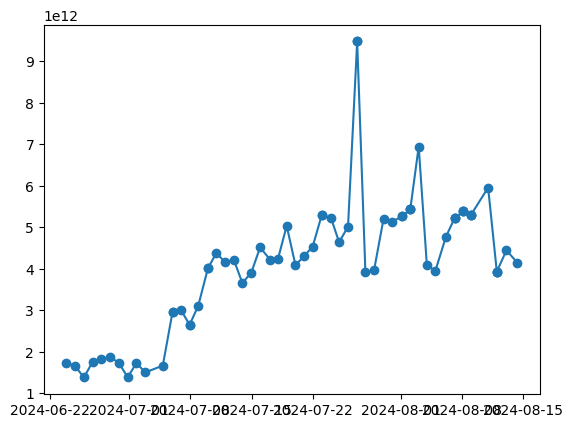

In [24]:
matplotlib.pyplot.plot(
    project_1_data["created_at"],
    project_1_data["total_bytes_read"],
    'o-',
)

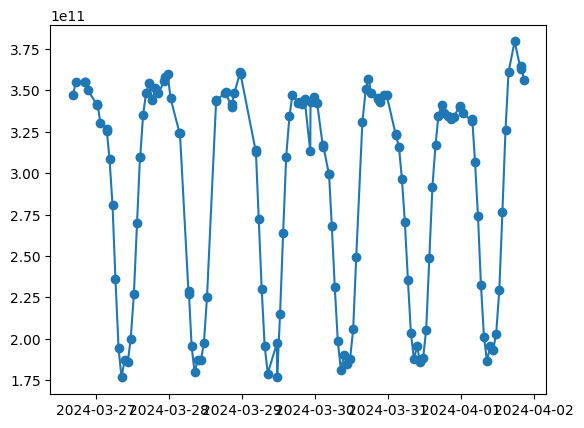

In [25]:
matplotlib.pyplot.plot(
    project_2_data["created_at"],
    project_2_data["total_bytes_read"],
    'o-',
)

These plots look quite different, so we may need different forecasting functions for each project.

We should first split the data into training and validation sets. 70% can go to train, and 30% validation.

In [26]:
train_set_1, val_set_1 = split_by_fraction(project_1_data, [0.7])
train_set_2, val_set_2 = split_by_fraction(project_2_data, [0.7])

In [27]:
len(train_set_1)

46

Now we try to fit the data using various statistics models and machine learning models to see which is the best fit for each of the projects.

We use a grid search and cross-validation (`GridSearchCV` from the `sklearn` package, using `TimeSeriesSplit` to get the cross-validation folds) for each estimator (with a wrapper for each of the `statsmodels` to be used as an `sklearn` estimator) on the project's `train_set` to determine which set of parameters in the `param_grid` best fit, along with options for how many past values (`past_points`) should be used as features (specifically geared towards the ML models; this is set to `0` for estimators derived from `statsmodels`). We then score each of these on the `val_set`, and record which estimator gave the best score.

In [28]:
forecast_methods = {
    "ARIMA": {
        "class": ARIMA,
        "param_grid": {
            # ARIMA (p, d, q):
            "order": [(1, 0, 0), (2, 1, 1)],
            # Trend types:
            "trend": [None],
        },
        "past_points": [0],
    },
    "SARIMA": {
        "class": SARIMAX,
        "param_grid": {
            # ARIMA (p, d, q):
            "order": [(1, 1, 1), (2, 1, 1)],
            # SARIMA (P, D, Q, S):
            "seasonal_order": [(1, 1, 1, 12)],
            # Trend types:
            "trend": ["n"],
            # Whether to enforce stationarity:
            "enforce_stationarity": [False],
            # Whether to enforce invertibility:
            "enforce_invertibility": [False],
        },
        "past_points": [0],
    },
    "Single Exponential Smoothing": {
        "class": SingleExponentialSmoothing,
        "param_grid": {
            "smoothing_level": [0, 0.3, 0.5],
        },
        "past_points": [0],
    },
    "Triple Exponential Smoothing": {
        "class": TripleExponentialSmoothing,
        "param_grid": {
            "trend": [None, "add", "mul"],
            "seasonal": [None, "add", "mul"],
            "seasonal_periods": [2, 3],
            "smoothing_level": [0, 0.3, 0.5],
            "smoothing_trend": [0, 0.3, 0.5],
            "smoothing_seasonal": [0, 0.3, 0.5],
        },
        "past_points": [0],
    },
    "Gaussian Naive Bayes": {
        "class": GaussianNaiveBayes,
        "param_grid": {
            'var_smoothing': [10**-9, 10**-10]
        },
        "past_points": [0,3,7],
    },
    "Random Forest": {
        "class": RandomForest,
        "param_grid": {
            "n_estimators": [1, 10],
            # The maximum depth of the tree.
            "max_depth": [None],
            # The minimum number of samples required
            # to split an internal node.
            "min_samples_split": [2, 4],
            # The minimum number of samples required
            # to be at a leaf node.
            "min_samples_leaf": [1],
            # The minimum weighted fraction of the sum
            # total of weights (of all the input samples)
            # required to be at a leaf node. Samples have
            # equal weight when sample_weight is not provided.
            "min_weight_fraction_leaf": [0.4],
            # The number of features to consider when looking 
            # for the best split.
            "max_features": ["sqrt", "log2"],
            # "max_leaf_nodes": [None],
            # "min_impurity_decrease": [0.0],
            "bootstrap": [True, False],
        },
        "past_points": [0,3,7],
    },
    "XGBoost": {
        "class": XGBoost,
        "param_grid": {
            # Number of gradient boosted trees.
            "n_estimators": [2,4,8],
            # Maximum tree depth for base learners.
            "max_depth": [2,4],
            # Maximum number of leaves; 0 indicates no limit.
            "max_leaves": [4],
            # If using histogram-based algorithm,
            # maximum number of bins per feature
            "max_bin": [2], 
            # Tree growing policy.
            "grow_policy": ["depthwise", "lossguide"],
            # Boosting learning rate (xgb’s “eta”).
            "learning_rate": [0.1,0.3],
            # (min_split_loss) Minimum loss reduction
            # required to make a further partition on
            # a leaf node of the tree.
            "gamma": [0.3],
        },
        "past_points": [0,3,7],
    },
}

In [29]:
project_1_forecast = Forecast(
    train_set_1["created_at"],
    train_set_1["total_bytes_read"],
    val_set_1["created_at"],
    val_set_1["total_bytes_read"],
    methods=forecast_methods,
    verbose=1,
)

In [30]:
fit_1 = project_1_forecast.fit()

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-projec

Fitting 5 folds for each of 2 candidates, totalling 10 fits
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 var

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All par


At iterate    5    f=  3.65185D+00    |proj g|=  2.26169D-02

At iterate   10    f=  3.64807D+00    |proj g|=  2.95367D-02

At iterate   15    f=  3.64224D+00    |proj g|=  6.20450D-03
  ys=-1.250E-05  -gs= 3.509E-05 BFGS update SKIPPED

At iterate   20    f=  3.64181D+00    |proj g|=  1.09560D-02

At iterate   25    f=  3.64068D+00    |proj g|=  1.42040D-02

At iterate   30    f=  3.64027D+00    |proj g|=  2.30836D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     75      1     1     0   1.235D-02   3.640D+00
  F =   3.6402221952659235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/s


At iterate    5    f=  8.45612D+00    |proj g|=  4.80413D-02

At iterate   10    f=  8.44922D+00    |proj g|=  1.65953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   1.372D-06   8.449D+00
  F =   8.4492152697769285     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parame

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72533D+00    |proj g|=  1.16983D-01

At iterate    5    f=  3.64186D+00    |proj g|=  1.98228D-02

At iterate   10    f=  3.63811D+00    |proj g|=  2.88421D-03

At iterate   15    f=  3.63788D+00    |proj g|=  1.49614D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     26      1     0     0   1.496D-07   3.638D+00
  F =   3.6378794927512694     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49192D+00    |proj g|=  3.70888D-02

At iterate    5    f=  8.46682D+00    |proj g|=  5.68413D-02

At iterate   10    f=  8.45719D+00    |proj g|=  2.00877D-02

At iterate   15    f=  8.44882D+00    |proj g|=  7.94995D-03

At iterate   20    f=  8.44852D+00    |proj g|=  1.95316D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     27      1     0     0   1.953D-05   8.449D+00
  F =   8.4485184786424927     

CONVERG

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17444D+01    |proj g|=  4.96629D-02

At iterate    5    f=  1.17195D+01    |proj g|=  3.26828D-02

At iterate   10    f=  1.16393D+01    |proj g|=  7.16908D-02

At iterate   15    f=  1.16233D+01    |proj g|=  2.43369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     22      1     0     0   1.916D-06   1.162D+01
  F =   11.623282246849893     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Fitting 

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Mo

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/li

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
ARIMA:
	0 past points score: 7.531139956731233e+23
SARIMA:
	0 past points score: 1.2273433644862674e+26
Single Exponential Smoothing:
	0 past points score: 7.931959796638792e+23
Triple Exponential Smoothing:
	0 past points score: 6.436733379260461e+24
Gaussian Naive Bayes:
	0 past points score: 3.398970315084857e+24
	3 past points score: 1.3443011764701343e+25
	7 past points score: 7.538598395451502e+24
Random Forest:
	0 past points score: 8.430487987065868e+23
	3 past points score: 6.14675592479046e+23
	7 past points score: 1.0520147172792769e+24
XGBoost:
	0 past points score: 9.304043425926426e+23
	3 past points score: 2.137122572785666e+23
	7 past points score: 4.07133613422024e+23


In [31]:
project_2_forecast = Forecast(
    train_set_2["created_at"],
    train_set_2["total_bytes_read"],
    val_set_2["created_at"],
    val_set_2["total_bytes_read"],
    methods=forecast_methods,
    verbose=0,
)
project_2_forecast.fit()

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unc

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      0      1      0     0     0   0.000D+00  -0.000D+00
  F =  -0.0000000000000000     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.68764D+01    |proj g|=  9.32879D-04

At iterate   10    f=  1.68764D+01    |proj g|=  4.31228D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     12      1     0     0   4.312D-06   1.688D+01
  F =   16.876425766174901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -0.00000D+00    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate    5    f=  1.22778D+13    |proj g|=  9.31949D+16

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     26      1     0     0   9.319D+16   1.228D+13
  F =   12277845213808.125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16185D+01    |proj g|=  2.49512D-01

At iterate    5    f=  1.14969D+01    |proj g|=  2.31777D-02

At iterate   10    f=  1.14963D+01    |proj g|=  1.33372D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.



At iterate   15    f=  1.14962D+01    |proj g|=  7.17267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     24      1     0     0   2.129D-05   1.150D+01
  F =   11.496139786028140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48520D+01    |proj g|=  9.02305D-02

At iterate    5    f=  1.48384D+01    |proj g|=  3.02910D-03


 This problem is unconstrained.



At iterate   10    f=  1.48383D+01    |proj g|=  3.18979D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     14      1     0     0   6.164D-06   1.484D+01
  F =   14.838252996983522     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.69164D+01    |proj g|=  1.67918D-01

At iterate    5    f=  1.68673D+01    |proj g|=  1.18735D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.68656D+01    |proj g|=  2.30050D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     16      1     0     0   1.520D-06   1.687D+01
  F =   16.865535189021418     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.82565D+01    |proj g|=  1.17338D-01

At iterate    5    f=  1.82325D+01    |proj g|=  5.04189D-03

At iterate   10    f=  1.82324D+01    |proj g|=  3.33955D-06

       

/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/Users/benjamin/Library/Caches/pypoetry/virtualenvs/sync-project-5Xb-Itff-py3.12/lib/python3.12/site-packages/pandas/util/_decorators.py:213: EstimationWarning: Mo

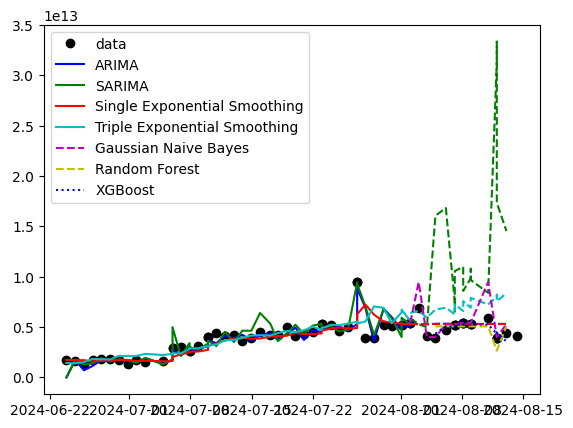

In [32]:
project_1_forecast.plot_all()

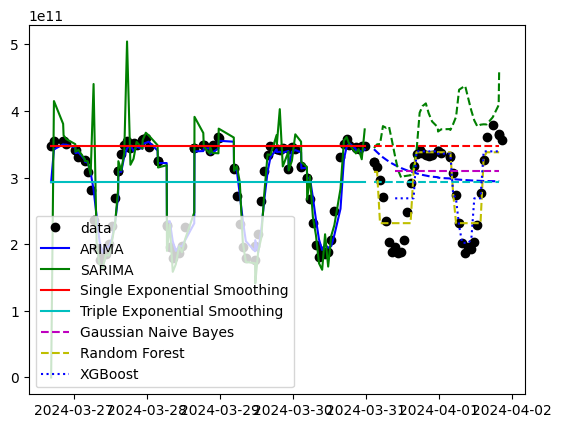

In [33]:
project_2_forecast.plot_all()

In [34]:
project_1_forecast.best_method_name

'XGBoost'

In [35]:
project_1_forecast.methods[project_1_forecast.best_method_name]["best_past_points"]

3

In [36]:
project_1_forecast.methods[project_1_forecast.best_method_name]["params"]

{'gamma': 0.3,
 'grow_policy': 'depthwise',
 'learning_rate': 0.3,
 'max_bin': 2,
 'max_depth': 2,
 'max_leaves': 4,
 'n_estimators': 8}

In [37]:
project_2_forecast.best_method_name

'XGBoost'

In [38]:
project_2_forecast.methods[project_2_forecast.best_method_name]["best_past_points"]

7

In [39]:
project_2_forecast.methods[project_2_forecast.best_method_name]["params"]

{'gamma': 0.3,
 'grow_policy': 'lossguide',
 'learning_rate': 0.3,
 'max_bin': 2,
 'max_depth': 4,
 'max_leaves': 4,
 'n_estimators': 8}

In [40]:
project_1_forecast.forecast(3)

In [41]:
project_2_forecast.forecast(12)

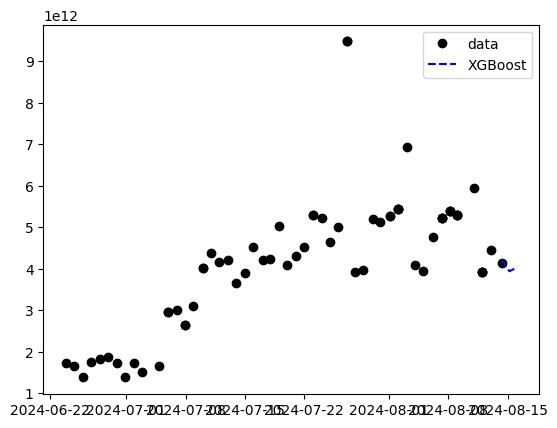

In [42]:
project_1_forecast.plot_best()

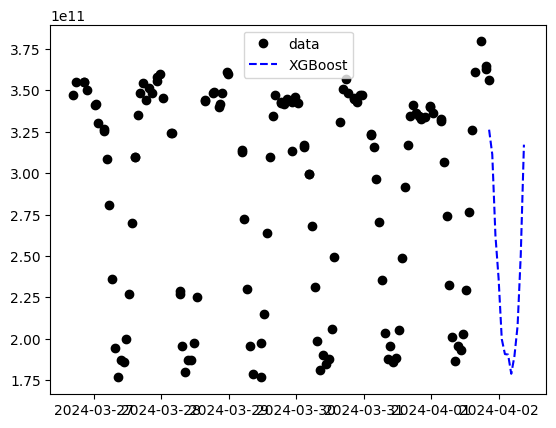

In [43]:
project_2_forecast.plot_best()

In [44]:
print(f"\nProject ID {ID1}:")
print(f"Best forecast method: {project_1_forecast.best_method_name}")
print(f"Best past points: {project_1_forecast.best_past_points}")
print(f"Best params: {project_1_forecast.methods[project_1_forecast.best_method_name]['params']}")
print(f"Best score: {project_1_forecast.methods[project_1_forecast.best_method_name][project_1_forecast.metric.__name__]}")
print(f"Last dataset time: {project_1_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_1_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)")
for ind, a_time in enumerate(project_1_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_1_forecast.best_forecast_forecast[ind]}")
print("\n")
print(f"Project ID {ID2}:")
print(f"Best forecast method: {project_2_forecast.best_method_name}")
print(f"Best past points: {project_2_forecast.best_past_points}")
print(f"Best params: {project_2_forecast.methods[project_2_forecast.best_method_name]['params']}")
print(f"Best score: {project_2_forecast.methods[project_2_forecast.best_method_name][project_2_forecast.metric.__name__]}")
print(f"Last dataset time: {project_2_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_2_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)")
for ind, a_time in enumerate(project_2_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_2_forecast.best_forecast_forecast[ind]}")


Project ID 480cc3f789be:
Best forecast method: XGBoost
Best past points: 3
Best params: {'gamma': 0.3, 'grow_policy': 'depthwise', 'learning_rate': 0.3, 'max_bin': 2, 'max_depth': 2, 'max_leaves': 4, 'n_estimators': 8}
Best score: 2.137122572785666e+23
Last dataset time: 2024-08-14T07:55:07.775000000
Average dataset time frequency: 75326409933333 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)
	2024-08-14T07:55:07.775000000	[4.200526e+12]
	2024-08-15T04:50:34.184933333	[3.934934e+12]
	2024-08-16T01:46:00.594866666	[4.0248106e+12]


Project ID 235c88aba875:
Best forecast method: XGBoost
Best past points: 7
Best params: {'gamma': 0.3, 'grow_policy': 'lossguide', 'learning_rate': 0.3, 'max_bin': 2, 'max_depth': 4, 'max_leaves': 4, 'n_estimators': 8}
Best score: 1.1117351229209038e+21
Last dataset time: 2024-04-01T20:37:57.787000000
Average dataset time frequency: 4056196638297 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)
	2024-04-01T20:37:57

## 2. Curve Fitting

First, let us examine the data we intend to fit:

In [45]:
group = data.groupby("project_id")

project_id
01f3531ee4d1    Axes(0.125,0.11;0.775x0.77)
17e698bda958    Axes(0.125,0.11;0.775x0.77)
235c88aba875    Axes(0.125,0.11;0.775x0.77)
480cc3f789be    Axes(0.125,0.11;0.775x0.77)
55c2412ae136    Axes(0.125,0.11;0.775x0.77)
cfd61b077a91    Axes(0.125,0.11;0.775x0.77)
dtype: object

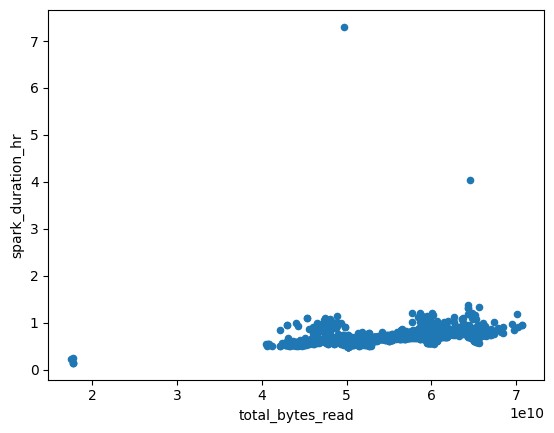

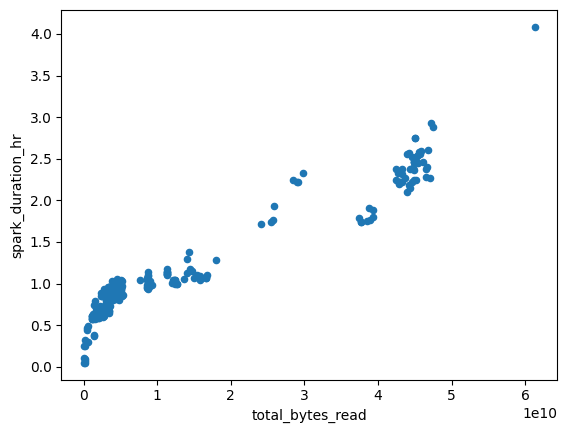

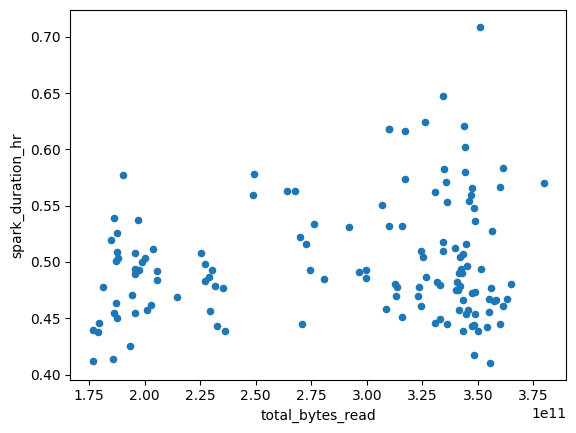

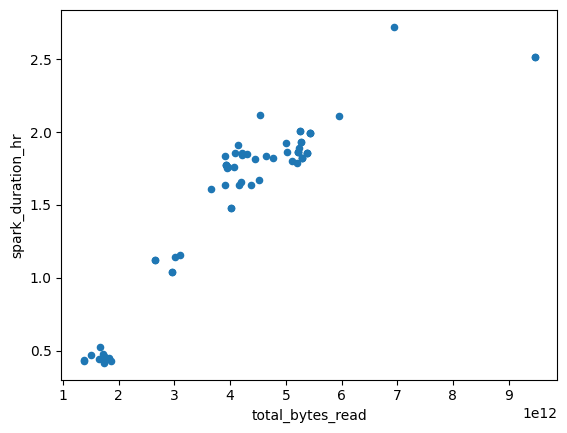

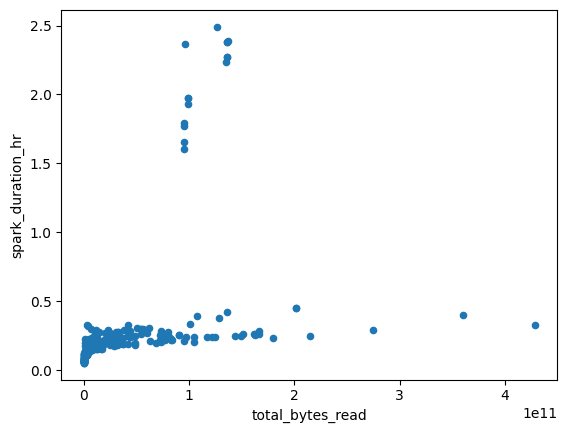

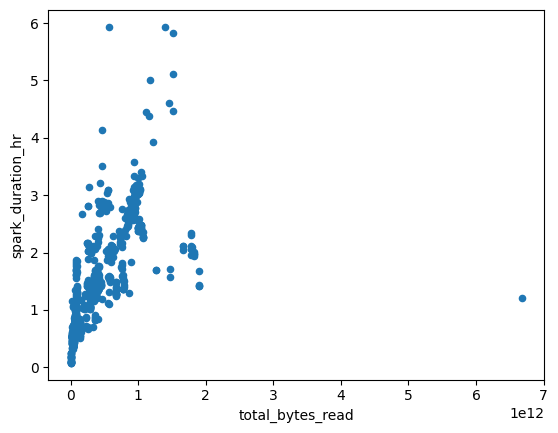

In [46]:
group.plot(
    x="total_bytes_read",
    y="spark_duration_hr",
    kind="scatter",
)

In [47]:
function_methods = {
    "5th Order Polynomial": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
            # The linear term coefficient:
            "coef_1": [1],
            # The quadratic term coefficient:
            "coef_2": [1],
            # The cubic term coefficient:
            "coef_3": [1],
            # The quartic term coefficient:
            "coef_4": [1],
            # The fifth term coefficient:
            "coef_5": [1],
        },
    },
    "Quartic": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
            # The linear term coefficient:
            "coef_1": [1],
            # The quadratic term coefficient:
            "coef_2": [1],
            # The cubic term coefficient:
            "coef_3": [1],
            # The quartic term coefficient:
            "coef_4": [1],
        },
    },
    "Cubic": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
            # The linear term coefficient:
            "coef_1": [1],
            # The quadratic term coefficient:
            "coef_2": [1],
            # The cubic term coefficient:
            "coef_3": [1],
        },
    },
    "Quadratic": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
            # The linear term coefficient:
            "coef_1": [1],
            # The quadratic term coefficient:
            "coef_2": [1],
        },
    },
    "Linear": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
            # The linear term coefficient:
            "coef_1": [1],
        },
    },
    "Constant": {
        "class": Polynomial,
        "param_grid": {
            # The constant term:
            "coef_0": [1],
        },
    },
    "Sine": {
        "class": Sine,
        "param_grid": {
            # Amplitude:
            "a": [1],
            # Frequency:
            "b": [1],
            # Phase shift:
            "c": [1],
            # y-intercept:
            "d": [1],
        },
    },
    "Exponential": {
        "class": Exponential,
        "param_grid": {
            # Rate of change at each point:
            "a": [1],
            # Change of base:
            "b": [1],
            # y-intercept + 1:
            "c": [1],
        },
    },
    "Gaussian": {
        "class": Gaussian,
        "param_grid": {
            # Height of the curve's peak:
            "a": [1],
            # Position of center of peak:
            "b": [1],
            # Standard deviation, width of "bell":
            "c": [1],
        },
    },
    "Logistic": {
        "class": Logistic,
        "param_grid": {
            # Carrying capacity:
            "a": [1],
            # Logistic growth rate.
            "b": [1],
            # x-value at funtion's midpoint.
            "c": [1],
        },
    },
}

In [48]:
group = data.groupby("project_id").apply(lambda x: x.sort_values(by="created_at",axis=0))
project_ids = group.index.get_level_values("project_id").unique()
groups_dict ={}
for key in project_ids:
    g_sorted = group.loc[key]
    fitter = FunctionFitter(
        g_sorted["total_bytes_read"],
        g_sorted["spark_duration_hr"],
        g_sorted["total_bytes_read"],
        g_sorted["spark_duration_hr"],
        methods=function_methods,
        cv=None,
        verbose=0,
    )
    fitter.fit()
    groups_dict[key] = {
        "fitter": fitter,
        "scores": [
            fitter.methods[meth][fitter.metric.__name__]
            for meth in fitter.methods
        ],
        "fits": [
            fitter.methods[meth]["fit"]
            for meth in fitter.methods
        ],
        "fits_times": [
            fitter.methods[meth]["fit_times"]
            for meth in fitter.methods
        ],
        "params": [
            fitter.methods[meth]["params"]
            for meth in fitter.methods
        ],
        "objects": [
            fitter.methods[meth]["result_object"]
            for meth in fitter.methods
        ],
        "data": g_sorted,
    }
methods_dict = {}
for ind, key in enumerate(function_methods.keys()):
    methods_dict[key] = {
        "scores": [
            grp["scores"][ind]
            for grp in groups_dict.values()
        ],
    }
    methods_dict[key].update(
        {
            "mean_score": numpy.mean(
                methods_dict[key]["scores"]
            )
        }
    )
best_func = min(
    methods_dict,
    key=lambda v: methods_dict[v]["mean_score"],
)

/var/folders/p2/5r1yrhzn1qvcbwpxt6gpjglc0000gn/T/ipykernel_49661/2737271113.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  group = data.groupby("project_id").apply(lambda x: x.sort_values(by="created_at",axis=0))
/Volumes/Files/Documents/Occupation/Career Search Post SmartThings/Companies/Stabile Search/Senior Data Scientist (Remote - $200k)/sync_project/src/sync_project/function_fitting/curve_fit_wrapper.py:87: OptimizeWarning: Covariance of the parameters could not be estimated
  curve_fit(
/Volumes/Files/Documents/Occupation/Career Search Post SmartThings/Companies/Stabile Search/Senior Data Scientist (Remote - $200k)/sync_project/src/sync_project/function_fitting/exponential.py:28: Runti

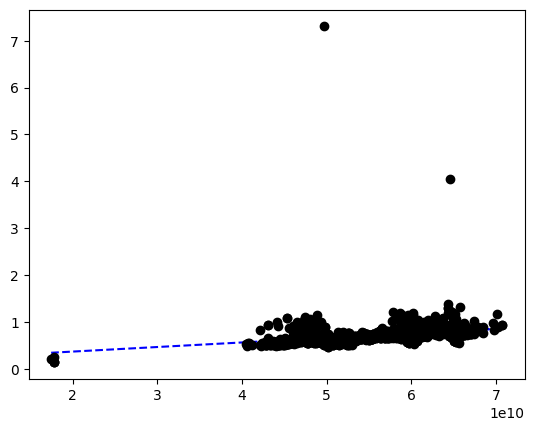

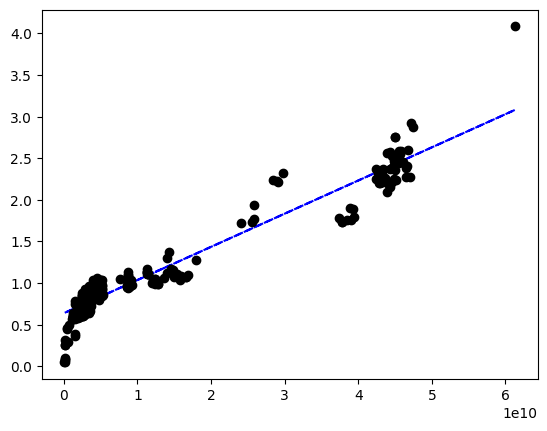

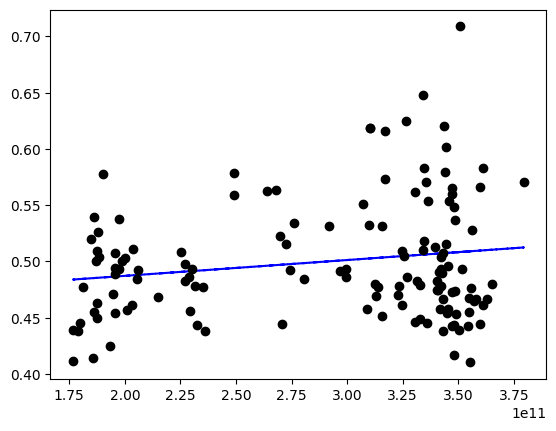

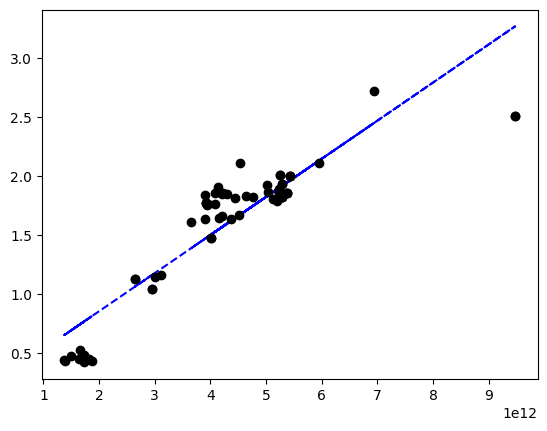

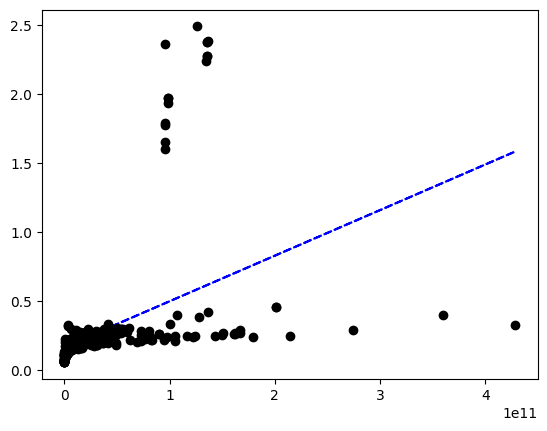

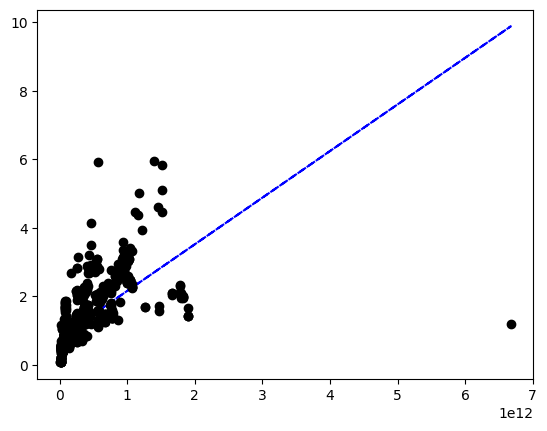

In [49]:
for key in project_ids:
    g = group.loc[key]
    matplotlib.pyplot.figure()
    matplotlib.pyplot.plot(
        groups_dict[key]["fitter"].methods[best_func]["fit_times"],
        groups_dict[key]["fitter"].methods[best_func]["fit"],
        'b--',
        label=best_func,
    )
    matplotlib.pyplot.plot(
        g["total_bytes_read"],
        g["spark_duration_hr"],
        'ko',
        label=f"{key} data",
    )

In [50]:
print(f"Best function: {best_func}")
print(f"Best score: {methods_dict[best_func]}")
print("params:")
for key, val in groups_dict.items():
    print(f"{key}: {val['fitter'].methods[best_func]['params']}")

Best function: Linear
Best score: {'scores': [np.float64(0.05032027911811351), np.float64(0.03102170078985814), np.float64(0.002713944700342949), np.float64(0.05641803608984205), np.float64(0.13054440845252488), np.float64(0.42749391117884583)], 'mean_score': np.float64(0.11641871338825456)}
params:
01f3531ee4d1: [9.71662431e-12 1.78948794e-01]
17e698bda958: [3.98644538e-11 6.38315639e-01]
235c88aba875: [1.40576927e-13 4.59099421e-01]
480cc3f789be: [3.23836753e-13 2.03587955e-01]
55c2412ae136: [3.30840152e-12 1.65313442e-01]
cfd61b077a91: [1.35870405e-12 8.00204801e-01]


## 3. Extrapolation

Now we extrapolate the duration for the forecasts for the two job IDs. 

In [51]:
print("Future durations:")
print(f"Project ID {ID1}:")
print(f"Last dataset time: {project_1_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_1_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)\tduration (spark_duration_hr)")
for ind, a_time in enumerate(project_1_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_1_forecast.best_forecast_forecast[ind]}\t{groups_dict[ID1]['fitter'].methods[best_func]['result_object'].predict(project_1_forecast.best_forecast_forecast[ind])}")
print(f"Project ID {ID2}:")
print(f"Last dataset time: {project_2_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_2_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)\tduration (spark_duration_hr)")
for ind, a_time in enumerate(project_2_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_2_forecast.best_forecast_forecast[ind]}\t{groups_dict[ID2]['fitter'].methods[best_func]['result_object'].predict(project_2_forecast.best_forecast_forecast[ind])}")


Future durations:
Project ID 480cc3f789be:
Last dataset time: 2024-08-14T07:55:07.775000000
Average dataset time frequency: 75326409933333 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)	duration (spark_duration_hr)
	2024-08-14T07:55:07.775000000	[4.200526e+12]	[1.56387265]
	2024-08-15T04:50:34.184933333	[3.934934e+12]	[1.47786421]
	2024-08-16T01:46:00.594866666	[4.0248106e+12]	[1.50696955]
Project ID 235c88aba875:
Last dataset time: 2024-04-01T20:37:57.787000000
Average dataset time frequency: 4056196638297 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)	duration (spark_duration_hr)
	2024-04-01T20:37:57.787000000	[3.2631937e+11]	[0.5049724]
	2024-04-01T21:45:33.983638297	[3.114325e+11]	[0.50287965]
	2024-04-01T22:53:10.180276594	[2.6244543e+11]	[0.49599319]
	2024-04-02T00:00:46.376914891	[2.3654121e+11]	[0.49235166]
	2024-04-02T01:08:22.573553188	[1.9990836e+11]	[0.48720192]
	2024-04-02T02:15:58.770191485	[1.9081929e+11]	[0.48592421]
	2024-0

## Summary

Here we summarize the findings from above.


Project ID 480cc3f789be:
Best forecast method: XGBoost
Best past points: 3
Best params: {'gamma': 0.3, 'grow_policy': 'depthwise', 'learning_rate': 0.3, 'max_bin': 2, 'max_depth': 2, 'max_leaves': 4, 'n_estimators': 8}
Best score: 2.137122572785666e+23
Last dataset time: 2024-08-14T07:55:07.775000000
Average dataset time frequency: 75326409933333 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)
	2024-08-14T07:55:07.775000000	[4.200526e+12]
	2024-08-15T04:50:34.184933333	[3.934934e+12]
	2024-08-16T01:46:00.594866666	[4.0248106e+12]


Project ID 235c88aba875:
Best forecast method: XGBoost
Best past points: 7
Best params: {'gamma': 0.3, 'grow_policy': 'lossguide', 'learning_rate': 0.3, 'max_bin': 2, 'max_depth': 4, 'max_leaves': 4, 'n_estimators': 8}
Best score: 1.1117351229209038e+21
Last dataset time: 2024-04-01T20:37:57.787000000
Average dataset time frequency: 4056196638297 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)
	2024-04-01T20:37:57

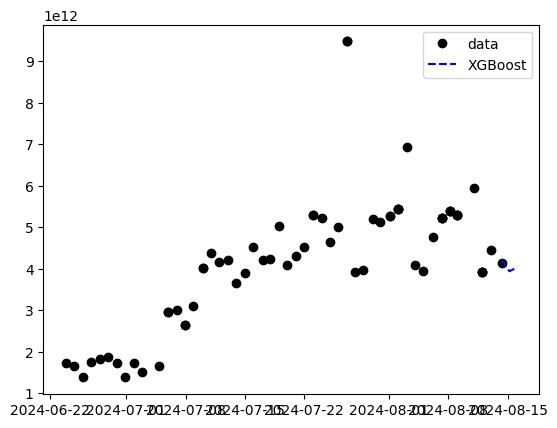

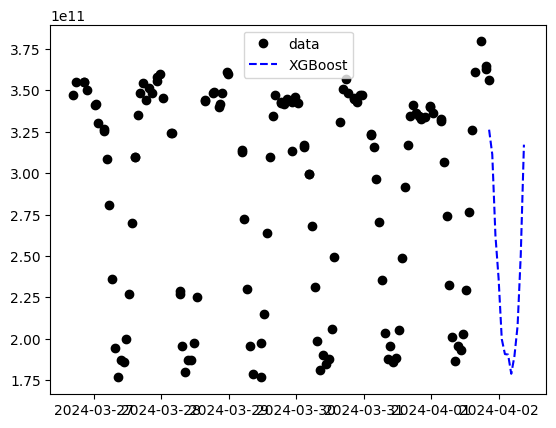

In [52]:
print(f"\nProject ID {ID1}:")
print(f"Best forecast method: {project_1_forecast.best_method_name}")
print(f"Best past points: {project_1_forecast.best_past_points}")
print(f"Best params: {project_1_forecast.methods[project_1_forecast.best_method_name]['params']}")
print(f"Best score: {project_1_forecast.methods[project_1_forecast.best_method_name][project_1_forecast.metric.__name__]}")
print(f"Last dataset time: {project_1_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_1_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)")
for ind, a_time in enumerate(project_1_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_1_forecast.best_forecast_forecast[ind]}")
print("\n")
print(f"Project ID {ID2}:")
print(f"Best forecast method: {project_2_forecast.best_method_name}")
print(f"Best past points: {project_2_forecast.best_past_points}")
print(f"Best params: {project_2_forecast.methods[project_2_forecast.best_method_name]['params']}")
print(f"Best score: {project_2_forecast.methods[project_2_forecast.best_method_name][project_2_forecast.metric.__name__]}")
print(f"Last dataset time: {project_2_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_2_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)")
for ind, a_time in enumerate(project_2_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_2_forecast.best_forecast_forecast[ind]}")
project_1_forecast.plot_best()
project_2_forecast.plot_best()

The above two plots depict the data points and the forecasts using the best method found.

I also note that there are likely parameters (and methods/estimators) that will provide better fits, as the best scores from the above were found over a small sample of possible parameters (and methods/estimators) which could be included in the grid searches and not an exhaustive list. But the square root of the scores (since the scores aer mean squared error) are each an order of magnitude smaller than the corresponding data points, so the errors are fairly small relative to the values in the dataset.

In [53]:
print(f"Best function: {best_func}")
print(f"Best score: {methods_dict[best_func]}")
print("params:")
for key, val in groups_dict.items():
    print(f"{key}: {val['fitter'].methods[best_func]['params']}")

Best function: Linear
Best score: {'scores': [np.float64(0.05032027911811351), np.float64(0.03102170078985814), np.float64(0.002713944700342949), np.float64(0.05641803608984205), np.float64(0.13054440845252488), np.float64(0.42749391117884583)], 'mean_score': np.float64(0.11641871338825456)}
params:
01f3531ee4d1: [9.71662431e-12 1.78948794e-01]
17e698bda958: [3.98644538e-11 6.38315639e-01]
235c88aba875: [1.40576927e-13 4.59099421e-01]
480cc3f789be: [3.23836753e-13 2.03587955e-01]
55c2412ae136: [3.30840152e-12 1.65313442e-01]
cfd61b077a91: [1.35870405e-12 8.00204801e-01]


The problem statement suggests that Linear is not the function family that best fits all the data, but the calculations above report otherwise. 
The discrepancy may lie in the outlier data points which have not been removed from the data when fitting the curves, or that the initial guesses for function family parameters have in some cases led to local minima which are not global minima.

In [54]:
print("Future durations:")
print(f"Project ID {ID1}:")
print(f"Last dataset time: {project_1_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_1_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)\tduration (spark_duration_hr)")
for ind, a_time in enumerate(project_1_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_1_forecast.best_forecast_forecast[ind]}\t{groups_dict[ID1]['fitter'].methods[best_func]['result_object'].predict(project_1_forecast.best_forecast_forecast[ind])}")
print(f"Project ID {ID2}:")
print(f"Last dataset time: {project_2_forecast.validation_time_data[-1]}")
print(f"Average dataset time frequency: {project_2_forecast.forecast_frequency}")
print("Forecasts:")
print("\tTime (created_at)\tforecast (total_bytes_read)\tduration (spark_duration_hr)")
for ind, a_time in enumerate(project_2_forecast.best_forecast_times):
    print(f"\t{a_time}\t{project_2_forecast.best_forecast_forecast[ind]}\t{groups_dict[ID2]['fitter'].methods[best_func]['result_object'].predict(project_2_forecast.best_forecast_forecast[ind])}")


Future durations:
Project ID 480cc3f789be:
Last dataset time: 2024-08-14T07:55:07.775000000
Average dataset time frequency: 75326409933333 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)	duration (spark_duration_hr)
	2024-08-14T07:55:07.775000000	[4.200526e+12]	[1.56387265]
	2024-08-15T04:50:34.184933333	[3.934934e+12]	[1.47786421]
	2024-08-16T01:46:00.594866666	[4.0248106e+12]	[1.50696955]
Project ID 235c88aba875:
Last dataset time: 2024-04-01T20:37:57.787000000
Average dataset time frequency: 4056196638297 nanoseconds
Forecasts:
	Time (created_at)	forecast (total_bytes_read)	duration (spark_duration_hr)
	2024-04-01T20:37:57.787000000	[3.2631937e+11]	[0.5049724]
	2024-04-01T21:45:33.983638297	[3.114325e+11]	[0.50287965]
	2024-04-01T22:53:10.180276594	[2.6244543e+11]	[0.49599319]
	2024-04-02T00:00:46.376914891	[2.3654121e+11]	[0.49235166]
	2024-04-02T01:08:22.573553188	[1.9990836e+11]	[0.48720192]
	2024-04-02T02:15:58.770191485	[1.9081929e+11]	[0.48592421]
	2024-0

The predicted application durations 6 and 12 hours after the last submission for the first project (project 1, ID 480cc3f789be) are both 1.56387265 hours, since the average frequency of submission 20.924002759259167 hours is larger than both 6 and 12 hours.

For the second project (project 2, ID 235c88aba875), the average frequency of submission 1.126721288415834 hours is less than both 6 and 12 hours. Therefore, the predicted application durations 6 hours after the last submission is 0.48720192 hours, and for 12 hours is 0.49433186 hours.

In both of the above cases, the predicted application duration is taken as the predicted duration of the timestamp corresponding to the most recent prediction before the requested elapsed time since the most recent submission. An alternative option could be to interpolate between the two nearest prediction timestamps.